In [17]:
import jovian
jovian.commit(filename='prepro.ipynb')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Committed successfully! https://jovian.ai/hongbi/prepro


'https://jovian.ai/hongbi/prepro'

In [170]:
import urllib.parse
import urllib.request
import pandas as pd
import re
from tqdm.notebook import tqdm
import numpy as np
import pickle
import missingno as msno
import multiprocessing 
from multiprocessing import Manager, Pool
num_cores = int(110)
import random
from datar import f
from datar.dplyr import mutate, filter, if_else
from datar.tibble import tibble
from preprocessing import parallelize_dataframe

In [171]:
# load data : key: kinase, value: sequence
with open('/home/hb/python/phospho/kw/1traintruedata생성/mappingdict(KIN_ACC_ID)HMM.pickle', 'rb') as fr:
    mappingdict = pickle.load(fr)

# 정답 데이터
df1 = pd.read_csv('/home/hb/python/phospho/kw/1traintruedata생성/Kinase_Substrate_Dataset',encoding = 'ISO-8859-1', header = 2, delimiter = '\t') 
print(df1.columns)
df1.tail()

Index(['GENE', 'KINASE', 'KIN_ACC_ID', 'KIN_ORGANISM', 'SUBSTRATE',
       'SUB_GENE_ID', 'SUB_ACC_ID', 'SUB_GENE', 'SUB_ORGANISM', 'SUB_MOD_RSD',
       'SITE_GRP_ID', 'SITE_+/-7_AA', 'DOMAIN', 'IN_VIVO_RXN', 'IN_VITRO_RXN',
       'CST_CAT#'],
      dtype='object')


,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,SITE_GRP_ID,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#
,<object>,<object>,<object>,<object>,<object>,<float64>,<object>,<object>,<object>,<object>,<int64>,<object>,<object>,<object>,<object>,<object>
21224,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S855,3205935,QRVLDtssLtQsAPA,NaN,X,,NaN
21225,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S859,2024885,DtssLtQsAPAsPtN,NaN,X,,NaN
21226,ULK2,ULK2,Q8IYT8,human,SEC16A,9919.0,O15027,SEC16A,human,S846,55578720,LAQPINFsVSLSNSH,NaN,X,,NaN
21227,ULK2,ULK2,Q8IYT8,human,PIK3C3,5289.0,Q8NEB9,PIK3C3,human,S249,35483209,ESsPILTsFELVKVP,NaN,X,,13857
21228,ULK2,ULK2,Q8IYT8,human,DENND3,22898.0,A2RUS2,DENND3,human,S472,7997148,THRRMVVsMPNLQDI,NaN,,X,NaN


In [243]:
ptm_human

,UniProt_ID,Kinase,Organism,UniProt_AC,Location,Modification,Reference,Substrate_Peptides,Substrate,ID,length
,<object>,<object>,<object>,<object>,<float64>,<object>,<object>,<object>,<object>,<object>,<int64>
0,IMA3_HUMAN,IMA3,HUMAN,O00629,24.0,Phosphorylation,18212344,NFKNKGRDLETMRRQRNEVVV,NKGRDLETMRRQRNE,IMA3_NKGRDLETMRRQRNE,15
1,IMA3_HUMAN,IMA3,HUMAN,O00629,60.0,Phosphorylation,29255136;22167270;23927012;18707149;25159151;2...,NVPHEDICEDSDIDGDYRVQN,HEDICEDSDIDGDYR,IMA3_HEDICEDSDIDGDYR,15
2,IMA3_HUMAN,IMA3,HUMAN,O00629,66.0,Phosphorylation,23927012;28674151;25852190;28796482;29978859;2...,ICEDSDIDGDYRVQNTSLEAI,DSDIDGDYRVQNTSL,IMA3_DSDIDGDYRVQNTSL,15
3,IMA3_HUMAN,IMA3,HUMAN,O00629,71.0,Phosphorylation,30278072;20068231;27050516;28176443;21712546;2...,DIDGDYRVQNTSLEAIVQNAS,GDYRVQNTSLEAIVQ,IMA3_GDYRVQNTSLEAIVQ,15
...,...,...,...,...,...,...,...,...,...,...,...
4,IMA3_HUMAN,IMA3,HUMAN,O00629,72.0,Phosphorylation,28464451;30278072;20068231;25159151;21955146;2...,IDGDYRVQNTSLEAIVQNASS,DYRVQNTSLEAIVQN,IMA3_DYRVQNTSLEAIVQN,15
470661,VINEX_HUMAN,VINEX,HUMAN,O60504,556.0,Phosphorylation,18669648,PSALRSPADPTDLGGQTSPRR,LRSPADPTDLGGQTS,VINEX_LRSPADPTDLGGQTS,15
470662,YD002_HUMAN,YD002,HUMAN,Q6ZU11,706.0,Phosphorylation,17081983,NQIAENSNLFSEDAQPQPFIL,AENSNLFSEDAQPQP,YD002_AENSNLFSEDAQPQP,15
470663,YS059_HUMAN,YS059,HUMAN,Q8N7K9,191.0,Phosphorylation,17525332,RIQLSSGVQSSPGTQAIAAIE,LSSGVQSSPGTQAIA,YS059_LSSGVQSSPGTQAIA,15


In [172]:
df2 = df1.dropna(subset=['KIN_ACC_ID'])
print(df2.columns)
df2.reset_index(drop=True, inplace=True)
df2.tail()

Index(['GENE', 'KINASE', 'KIN_ACC_ID', 'KIN_ORGANISM', 'SUBSTRATE',
       'SUB_GENE_ID', 'SUB_ACC_ID', 'SUB_GENE', 'SUB_ORGANISM', 'SUB_MOD_RSD',
       'SITE_GRP_ID', 'SITE_+/-7_AA', 'DOMAIN', 'IN_VIVO_RXN', 'IN_VITRO_RXN',
       'CST_CAT#'],
      dtype='object')


,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,SITE_GRP_ID,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#
,<object>,<object>,<object>,<object>,<object>,<float64>,<object>,<object>,<object>,<object>,<int64>,<object>,<object>,<object>,<object>,<object>
21221,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S855,3205935,QRVLDtssLtQsAPA,NaN,X,,NaN
21222,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S859,2024885,DtssLtQsAPAsPtN,NaN,X,,NaN
21223,ULK2,ULK2,Q8IYT8,human,SEC16A,9919.0,O15027,SEC16A,human,S846,55578720,LAQPINFsVSLSNSH,NaN,X,,NaN
21224,ULK2,ULK2,Q8IYT8,human,PIK3C3,5289.0,Q8NEB9,PIK3C3,human,S249,35483209,ESsPILTsFELVKVP,NaN,X,,13857
21225,ULK2,ULK2,Q8IYT8,human,DENND3,22898.0,A2RUS2,DENND3,human,S472,7997148,THRRMVVsMPNLQDI,NaN,,X,NaN


In [173]:
df2['KIN_ACC_ID'] = df2['KIN_ACC_ID'].apply(lambda x:x.replace("-2","")
                                            .replace("-3","")
                                            .replace("-8","")
                                            .replace("-10",""))
df2['KIN_ACC_ID'].unique()
df2.reset_index(drop=True, inplace=True)
df2.tail()

/tmp/ipykernel_1628312/2962801615.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['KIN_ACC_ID'] = df2['KIN_ACC_ID'].apply(lambda x:x.replace("-2","")


,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,SITE_GRP_ID,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#
,<object>,<object>,<object>,<object>,<object>,<float64>,<object>,<object>,<object>,<object>,<int64>,<object>,<object>,<object>,<object>,<object>
21221,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S855,3205935,QRVLDtssLtQsAPA,NaN,X,,NaN
21222,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S859,2024885,DtssLtQsAPAsPtN,NaN,X,,NaN
21223,ULK2,ULK2,Q8IYT8,human,SEC16A,9919.0,O15027,SEC16A,human,S846,55578720,LAQPINFsVSLSNSH,NaN,X,,NaN
21224,ULK2,ULK2,Q8IYT8,human,PIK3C3,5289.0,Q8NEB9,PIK3C3,human,S249,35483209,ESsPILTsFELVKVP,NaN,X,,13857
21225,ULK2,ULK2,Q8IYT8,human,DENND3,22898.0,A2RUS2,DENND3,human,S472,7997148,THRRMVVsMPNLQDI,NaN,,X,NaN


In [174]:
df2 = df2[df2['KIN_ACC_ID'].isin(mappingdict.keys())]
df2.reset_index(drop=True, inplace=True)
df2.tail()

,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,SITE_GRP_ID,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#
,<object>,<object>,<object>,<object>,<object>,<float64>,<object>,<object>,<object>,<object>,<int64>,<object>,<object>,<object>,<object>,<object>
17716,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S855,3205935,QRVLDtssLtQsAPA,NaN,X,,NaN
17717,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S859,2024885,DtssLtQsAPAsPtN,NaN,X,,NaN
17718,ULK2,ULK2,Q8IYT8,human,SEC16A,9919.0,O15027,SEC16A,human,S846,55578720,LAQPINFsVSLSNSH,NaN,X,,NaN
17719,ULK2,ULK2,Q8IYT8,human,PIK3C3,5289.0,Q8NEB9,PIK3C3,human,S249,35483209,ESsPILTsFELVKVP,NaN,X,,13857
17720,ULK2,ULK2,Q8IYT8,human,DENND3,22898.0,A2RUS2,DENND3,human,S472,7997148,THRRMVVsMPNLQDI,NaN,,X,NaN


In [175]:
df2

,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,SITE_GRP_ID,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#
,<object>,<object>,<object>,<object>,<object>,<float64>,<object>,<object>,<object>,<object>,<int64>,<object>,<object>,<object>,<object>,<object>
0,Dyrk2,DYRK2,Q5U4C9,mouse,NDEL1,83431.0,Q9ERR1,Ndel1,mouse,S336,1869686801,LGSsRPSsAPGMLPL,NaN,,X,NaN
1,Pak2,PAK2,Q64303,rat,MEK1,170851.0,Q01986,Map2k1,rat,S298,448284,RtPGRPLsSYGMDSR,Pkinase,,X,9128; 98195
2,Pak2,PAK2,Q64303,rat,PRKD1,85421.0,Q9WTQ1,Prkd1,rat,S203,449896,GVRRRRLsNVsLTGL,NaN,X,,NaN
3,Pak2,PAK2,Q64303,rat,prolactin,24683.0,P01237,Prl,rat,S206,451732,IRCLRRDsHKVDNYL,Hormone_1,,X,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,Pak2,PAK2,Q64303,rat,prolactin,5617.0,P01236,PRL,human,S207,451732,LHCLRRDsHKIDNYL,Hormone_1,,X,NaN
17716,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S855,3205935,QRVLDtssLtQsAPA,NaN,X,,NaN
17717,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S859,2024885,DtssLtQsAPAsPtN,NaN,X,,NaN
17718,ULK2,ULK2,Q8IYT8,human,SEC16A,9919.0,O15027,SEC16A,human,S846,55578720,LAQPINFsVSLSNSH,NaN,X,,NaN


<AxesSubplot:>

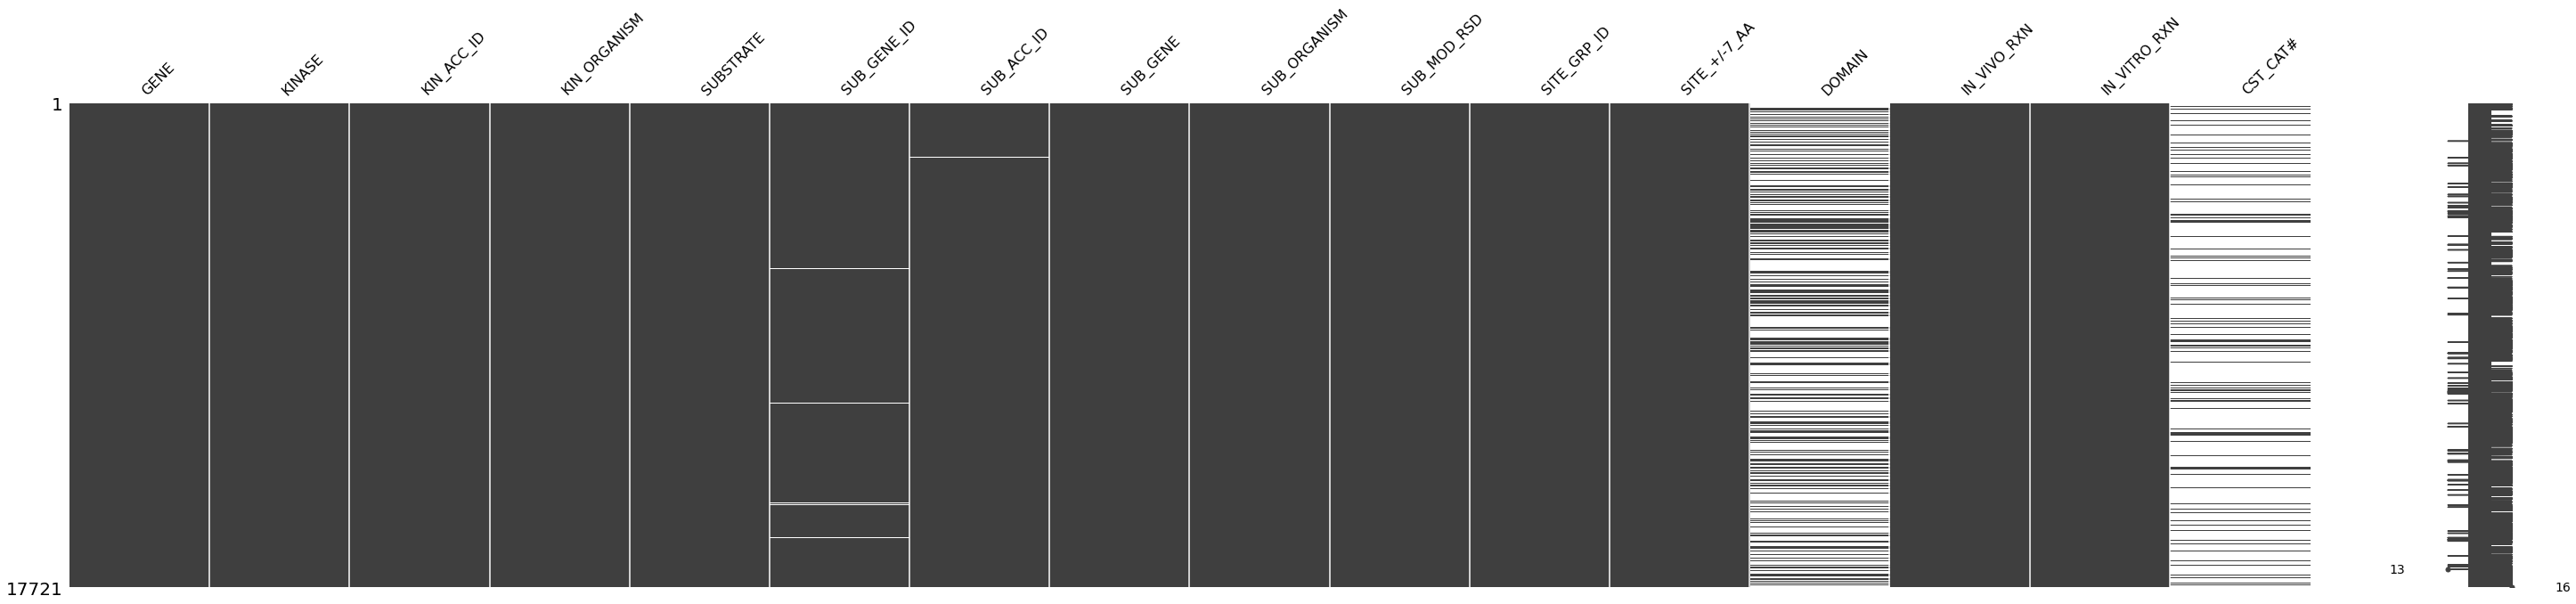

In [176]:
msno.matrix(df2, figsize=(50,10)) # 결측치 조회

amax    336.000000
amin     61.000000
mean    263.058857
Name: Length, dtype: float64


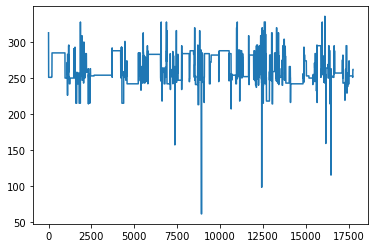

In [177]:
df2['KINseq'] = df2.apply(lambda x: mappingdict[x['KIN_ACC_ID']], axis=1)
df2['Length'] = df2.apply(lambda x: len(x['KINseq']), axis=1)
df2['Length'].plot()
len_info = df2['Length'].agg([np.max, np.min, np.mean])
max_len, min_len, mean_len = len_info
print(len_info)

In [178]:
df2['KINseq'] = df2['KINseq'].apply(lambda x:x.ljust(int(max_len),'0')) # 왼쪽으로 정렬 후 빈 값은 0으로 채워넣기
df2['KINseq'][0]

'YEVLKVIGKGSFGQVVKAYDHKVHQHVALKMVRNEKRFHRQAAEEIRILEHLRKQDKDNTMNVIHMLENFTFRNHICMTFELLSMNLYELIKKNKFQGFSLPLVRKFAHSILQCLDALHKNRIIHCDLKPENILLKQQGRSSIKVIDFGSSCYEHQRVYTYIQSRFYRAPEVILGARYGMPIDMWSLGCILAELLTGYPLLPGEDEGDQLACMIELLGMPSQKLLDASKRAKNFVSSKGYPRYCTVTTLSDGSVVLNGGRSRRGKLRGPPESREWGNALKGCDDPLFLDFLKQCLEWDPAVRMTPGQALRHPW00000000000000000000000'

In [179]:
print('before: ', df2['SITE_+/-7_AA'][:5])
df2['SITE_+/-7_AA'] = df2['SITE_+/-7_AA'].apply(lambda x:x.upper())
print('after: ', df2['SITE_+/-7_AA'][:5])

before:  0    LGSsRPSsAPGMLPL
1    RtPGRPLsSYGMDSR
2    GVRRRRLsNVsLTGL
3    IRCLRRDsHKVDNYL
4    LHCLRRDsHKIDNYL
Name: SITE_+/-7_AA, dtype: object
after:  0    LGSSRPSSAPGMLPL
1    RTPGRPLSSYGMDSR
2    GVRRRRLSNVSLTGL
3    IRCLRRDSHKVDNYL
4    LHCLRRDSHKIDNYL
Name: SITE_+/-7_AA, dtype: object


In [180]:
df2['answer'] = 1
df2.tail()

,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,SITE_GRP_ID,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#,KINseq,Length,answer
,<object>,<object>,<object>,<object>,<object>,<float64>,<object>,<object>,<object>,<object>,<int64>,<object>,<object>,<object>,<object>,<object>,<object>,<int64>,<int64>
17716,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S855,3205935,QRVLDTSSLTQSAPA,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1
17717,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S859,2024885,DTSSLTQSAPASPTN,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1
17718,ULK2,ULK2,Q8IYT8,human,SEC16A,9919.0,O15027,SEC16A,human,S846,55578720,LAQPINFSVSLSNSH,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1
17719,ULK2,ULK2,Q8IYT8,human,PIK3C3,5289.0,Q8NEB9,PIK3C3,human,S249,35483209,ESSPILTSFELVKVP,NaN,X,,13857,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1
17720,ULK2,ULK2,Q8IYT8,human,DENND3,22898.0,A2RUS2,DENND3,human,S472,7997148,THRRMVVSMPNLQDI,NaN,,X,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1


In [181]:
df3 = df2.drop_duplicates(['KINseq', 'SITE_+/-7_AA'])
df3.reset_index(drop=True, inplace=True)
df3.tail()

,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,SITE_GRP_ID,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#,KINseq,Length,answer
,<object>,<object>,<object>,<object>,<object>,<float64>,<object>,<object>,<object>,<object>,<int64>,<object>,<object>,<object>,<object>,<object>,<object>,<int64>,<int64>
16626,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S855,3205935,QRVLDTSSLTQSAPA,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1
16627,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S859,2024885,DTSSLTQSAPASPTN,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1
16628,ULK2,ULK2,Q8IYT8,human,SEC16A,9919.0,O15027,SEC16A,human,S846,55578720,LAQPINFSVSLSNSH,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1
16629,ULK2,ULK2,Q8IYT8,human,PIK3C3,5289.0,Q8NEB9,PIK3C3,human,S249,35483209,ESSPILTSFELVKVP,NaN,X,,13857,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1
16630,ULK2,ULK2,Q8IYT8,human,DENND3,22898.0,A2RUS2,DENND3,human,S472,7997148,THRRMVVSMPNLQDI,NaN,,X,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1


In [182]:
psph_human = df3[(df3['KIN_ORGANISM']=='human')&(df3['SUB_ORGANISM']=='human')]

## Make False data

In [183]:
hash_data = pd.read_csv("/home/hb/python/phospho/kw/1traintruedata생성/Calpha.txt", sep='\t')
display(hash_data.tail())
hash_data.drop(columns=['Unnamed: 0'], inplace=True)
display(hash_data.tail())
print(hash_data.columns)
characters = tuple(hash_data.columns)


,Unnamed: 0,L,F,I,M,V,W,C,Y,H,...,T,G,P,R,Q,S,N,E,D,K
,<object>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,...,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
15,S,0.020,-0.076,-0.025,0.000,0.021,-0.004,-0.191,-0.023,0.032,...,-0.017,-0.013,0.201,0.127,0.090,-0.108,0.024,0.196,0.060,0.178
16,N,0.139,0.039,0.043,0.080,0.139,0.028,-0.038,-0.003,0.133,...,0.033,0.048,0.288,0.209,0.053,0.024,-0.205,0.245,0.036,0.117
17,E,0.016,0.128,0.049,0.036,0.096,0.058,0.202,0.145,0.232,...,0.134,0.240,0.428,-0.157,0.106,0.196,0.245,0.181,0.396,-0.182
18,D,0.169,0.150,0.123,0.136,0.148,0.167,0.097,0.165,0.083,...,0.087,0.137,0.366,-0.038,0.130,0.060,0.036,0.396,0.301,-0.006
19,K,0.043,0.024,-0.014,0.121,0.057,0.017,0.156,-0.013,0.373,...,0.165,0.179,0.496,0.350,0.121,0.178,0.117,-0.182,-0.006,0.205


,L,F,I,M,V,W,C,Y,H,A,T,G,P,R,Q,S,N,E,D,K
,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
15,0.020,-0.076,-0.025,0.000,0.021,-0.004,-0.191,-0.023,0.032,-0.031,-0.017,-0.013,0.201,0.127,0.090,-0.108,0.024,0.196,0.060,0.178
16,0.139,0.039,0.043,0.080,0.139,0.028,-0.038,-0.003,0.133,0.046,0.033,0.048,0.288,0.209,0.053,0.024,-0.205,0.245,0.036,0.117
17,0.016,0.128,0.049,0.036,0.096,0.058,0.202,0.145,0.232,-0.012,0.134,0.240,0.428,-0.157,0.106,0.196,0.245,0.181,0.396,-0.182
18,0.169,0.150,0.123,0.136,0.148,0.167,0.097,0.165,0.083,0.073,0.087,0.137,0.366,-0.038,0.130,0.060,0.036,0.396,0.301,-0.006
19,0.043,0.024,-0.014,0.121,0.057,0.017,0.156,-0.013,0.373,0.075,0.165,0.179,0.496,0.350,0.121,0.178,0.117,-0.182,-0.006,0.205


Index(['L', 'F', 'I', 'M', 'V', 'W', 'C', 'Y', 'H', 'A', 'T', 'G', 'P', 'R',
       'Q', 'S', 'N', 'E', 'D', 'K'],
      dtype='object')


In [197]:
psph_human

,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,SITE_GRP_ID,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#,KINseq,Length,answer,ID
,<object>,<object>,<object>,<object>,<object>,<float64>,<object>,<object>,<object>,<object>,<int64>,<object>,<object>,<object>,<object>,<object>,<object>,<int64>,<int64>,<object>
7,PRKCD,PKCD,Q05655,human,HDAC5,10014.0,Q9UQL6,HDAC5,human,S259,447995,FPLRKTASEPNLKVR,NaN,,X,3443,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,251,1,Q05655_FPLRKTASEPNLKVR
8,PRKCD,PKCD,Q05655,human,PTPRA iso2,5786.0,P18433-2,PTPRA,human,S204,447612,PLLARSPSTNRKYPP,NaN,X,,NaN,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,251,1,Q05655_PLLARSPSTNRKYPP
9,PRKCD,PKCD,Q05655,human,Bcl-2,596.0,P10415,BCL2,human,S70,448395,RDPVARTSPLQTPAA,NaN,X,,2834; 2827,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,251,1,Q05655_RDPVARTSPLQTPAA
10,PRKCD,PKCD,Q05655,human,hnRNP K,3190.0,P61978,HNRNPK,human,S302,457408,GRGGRGGSRARNLPL,NaN,X,X,NaN,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,251,1,Q05655_GRGGRGGSRARNLPL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,PRKCD,PKCD,Q05655,human,SHOC2,8036.0,Q9UQ13,SHOC2,human,T71,34669125,VAFSVDNTIKRPNPA,NaN,,X,NaN,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,251,1,Q05655_VAFSVDNTIKRPNPA
16626,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S855,3205935,QRVLDTSSLTQSAPA,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1,Q8IYT8_QRVLDTSSLTQSAPA
16627,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S859,2024885,DTSSLTQSAPASPTN,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1,Q8IYT8_DTSSLTQSAPASPTN
16628,ULK2,ULK2,Q8IYT8,human,SEC16A,9919.0,O15027,SEC16A,human,S846,55578720,LAQPINFSVSLSNSH,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1,Q8IYT8_LAQPINFSVSLSNSH


In [198]:
psph_human['ID'] = psph_human['KIN_ACC_ID'] + '_' + psph_human['SITE_+/-7_AA']
psph_human_ = psph_human[['KIN_ACC_ID', 'KIN_ORGANISM', 'SITE_+/-7_AA', 'ID', 'KINseq']]
psph_human_.rename(columns=dict(zip(['KIN_ACC_ID', 'KIN_ORGANISM', 'SITE_+/-7_AA', 'ID', 'KINseq'], ['Kinase', 'Organism', 'Substrate', 'ID', 'KINseq'])), inplace=True)
psph_human_['type'] = 'psph'
psph_human_['answer'] = 1

/tmp/ipykernel_1628312/1658016171.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  psph_human['ID'] = psph_human['KIN_ACC_ID'] + '_' + psph_human['SITE_+/-7_AA']
/tmp/ipykernel_1628312/1658016171.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  psph_human_.rename(columns=dict(zip(['KIN_ACC_ID', 'KIN_ORGANISM', 'SITE_+/-7_AA', 'ID', 'KINseq'], ['Kinase', 'Organism', 'Substrate', 'ID', 'KINseq'])), inplace=True)
/tmp/ipykernel_1628312/1658016171.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [199]:
psph_human_

,Kinase,Organism,Substrate,ID,KINseq,type,answer
,<object>,<object>,<object>,<object>,<object>,<object>,<int64>
7,Q05655,human,FPLRKTASEPNLKVR,Q05655_FPLRKTASEPNLKVR,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,psph,1
8,Q05655,human,PLLARSPSTNRKYPP,Q05655_PLLARSPSTNRKYPP,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,psph,1
9,Q05655,human,RDPVARTSPLQTPAA,Q05655_RDPVARTSPLQTPAA,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,psph,1
10,Q05655,human,GRGGRGGSRARNLPL,Q05655_GRGGRGGSRARNLPL,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,psph,1
...,...,...,...,...,...,...,...
11,Q05655,human,VAFSVDNTIKRPNPA,Q05655_VAFSVDNTIKRPNPA,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,psph,1
16626,Q8IYT8,human,QRVLDTSSLTQSAPA,Q8IYT8_QRVLDTSSLTQSAPA,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,psph,1
16627,Q8IYT8,human,DTSSLTQSAPASPTN,Q8IYT8_DTSSLTQSAPASPTN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,psph,1
16628,Q8IYT8,human,LAQPINFSVSLSNSH,Q8IYT8_LAQPINFSVSLSNSH,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,psph,1


In [200]:
psph_human_['singleSITE'] = psph_human_['Substrate'].apply(lambda x: tuple(x))
psph_human_['singleSITE'][:5]
psph_human_.reset_index(drop=True, inplace=True)

/tmp/ipykernel_1628312/1714808582.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  psph_human_['singleSITE'] = psph_human_['Substrate'].apply(lambda x: tuple(x))


In [201]:
# # 무슨 코든지 모르겠으면 주석 풀고 보길
# from collections import Counter
# characters_sum = {i:0 for i in characters}
# print('시작', characters_sum)
# for row in df3['singleSITE'][:2]:
#     row_counter = Counter(row)
#     print(row_counter)
#     for key, value in row_counter.items():
#         characters_sum[key] = characters_sum[key] + value 
#     print('1 cycle 종료', characters_sum)
#     print('=='*20)

In [202]:
from collections import Counter

def calculate_aa_sum(df):
    characters_sum = {i:0 for i in characters}

    for row in df['singleSITE']:
        row_counter = Counter(row)
        for key, value in row_counter.items():
            if key == '_':
                pass
            else: 
                characters_sum[key] = characters_sum[key] + value 
    return characters_sum

In [203]:
aa_sum = calculate_aa_sum(psph_human_)

In [204]:
all_counts = sum(aa_sum.values())
aa_indexes = tuple(aa_sum.keys())
dfop = pd.DataFrame({'aa_counts':aa_sum.values()}, index=aa_indexes)
dfop.sort_index(inplace=True)
dfop['ratio'] = dfop['aa_counts'].apply(lambda x: x/sum(dfop['aa_counts']))

percentage = dfop['ratio']
total = sum(dfop['aa_counts'])
repeats = np.around(np.array(percentage) * total).astype(np.int64)  # [6, 3, 2]
characters = np.repeat(aa_indexes, repeats)
userId   = ''.join([random.choice(characters) for _ in range(15)]) #aa의 frequency에 따라 출현율 차등
df_false = psph_human_.copy()

def make_false_aa_seq(a):
    left = [random.choice(characters) for _ in range(7)]
    middle = [random.choice(['S', 'Y', 'T'])]
    right = [random.choice(characters) for _ in range(7)]
    aa = "".join(left+middle+right)
    return aa

df_false['answer'] = 0
df_false['Substrate'] = ''   
df_false['Substrate'] = df_false['Substrate'].apply(make_false_aa_seq)
df_false.reset_index(drop=True, inplace=True)
df = pd.concat([psph_human_, df_false],axis=0, ignore_index=True)

In [205]:
df

,Kinase,Organism,Substrate,ID,KINseq,type,answer,singleSITE
,<object>,<object>,<object>,<object>,<object>,<object>,<int64>,<object>
0,Q05655,human,FPLRKTASEPNLKVR,Q05655_FPLRKTASEPNLKVR,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,psph,1,"(F, P, L, R, K, T, A, S, E, P, N, L, K, V, R)"
1,Q05655,human,PLLARSPSTNRKYPP,Q05655_PLLARSPSTNRKYPP,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,psph,1,"(P, L, L, A, R, S, P, S, T, N, R, K, Y, P, P)"
2,Q05655,human,RDPVARTSPLQTPAA,Q05655_RDPVARTSPLQTPAA,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,psph,1,"(R, D, P, V, A, R, T, S, P, L, Q, T, P, A, A)"
3,Q05655,human,GRGGRGGSRARNLPL,Q05655_GRGGRGGSRARNLPL,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,psph,1,"(G, R, G, G, R, G, G, S, R, A, R, N, L, P, L)"
...,...,...,...,...,...,...,...,...
4,Q05655,human,VAFSVDNTIKRPNPA,Q05655_VAFSVDNTIKRPNPA,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,psph,1,"(V, A, F, S, V, D, N, T, I, K, R, P, N, P, A)"
20847,Q8IYT8,human,MSQLHNHYIQQLIRS,Q8IYT8_QRVLDTSSLTQSAPA,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,psph,0,"(Q, R, V, L, D, T, S, S, L, T, Q, S, A, P, A)"
20848,Q8IYT8,human,PPMPAAHYEQPTSWN,Q8IYT8_DTSSLTQSAPASPTN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,psph,0,"(D, T, S, S, L, T, Q, S, A, P, A, S, P, T, N)"
20849,Q8IYT8,human,PYIAVELTPWSNSMV,Q8IYT8_LAQPINFSVSLSNSH,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,psph,0,"(L, A, Q, P, I, N, F, S, V, S, L, S, N, S, H)"


In [206]:
from collections import namedtuple

kin = df['Kinase'].to_numpy()
kinseq = df['KINseq'].to_numpy()
kinase_seq_info_dict = {key: value 
                        if len(value)==336 else print('error') 
                        for key, value in zip(kin, kinseq)}

In [207]:
hash_data = pd.read_csv('/home/hb/python/phospho/kw/1traintruedata생성/Calpha.txt', sep='\t')
mayproblem = []
for i in kinase_seq_info_dict.values():
    for n in i:
        if n not in hash_data.columns:
            mayproblem.append(i)

In [208]:
# kinase error 체크
problem = []
for kinase_seq in df['Substrate']:
    assert len(kinase_seq) == 15
    if False in list(map(lambda x: x in list(hash_data.columns), kinase_seq)):
        problem.append(kinase_seq)

In [209]:
hash_data = pd.read_csv('/home/hb/python/phospho/kw/1traintruedata생성/Calpha.txt', sep='\t')
hash_data.set_index(hash_data['Unnamed: 0'], inplace=True)

In [210]:
df

,Kinase,Organism,Substrate,ID,KINseq,type,answer,singleSITE
,<object>,<object>,<object>,<object>,<object>,<object>,<int64>,<object>
0,Q05655,human,FPLRKTASEPNLKVR,Q05655_FPLRKTASEPNLKVR,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,psph,1,"(F, P, L, R, K, T, A, S, E, P, N, L, K, V, R)"
1,Q05655,human,PLLARSPSTNRKYPP,Q05655_PLLARSPSTNRKYPP,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,psph,1,"(P, L, L, A, R, S, P, S, T, N, R, K, Y, P, P)"
2,Q05655,human,RDPVARTSPLQTPAA,Q05655_RDPVARTSPLQTPAA,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,psph,1,"(R, D, P, V, A, R, T, S, P, L, Q, T, P, A, A)"
3,Q05655,human,GRGGRGGSRARNLPL,Q05655_GRGGRGGSRARNLPL,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,psph,1,"(G, R, G, G, R, G, G, S, R, A, R, N, L, P, L)"
...,...,...,...,...,...,...,...,...
4,Q05655,human,VAFSVDNTIKRPNPA,Q05655_VAFSVDNTIKRPNPA,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,psph,1,"(V, A, F, S, V, D, N, T, I, K, R, P, N, P, A)"
20847,Q8IYT8,human,MSQLHNHYIQQLIRS,Q8IYT8_QRVLDTSSLTQSAPA,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,psph,0,"(Q, R, V, L, D, T, S, S, L, T, Q, S, A, P, A)"
20848,Q8IYT8,human,PPMPAAHYEQPTSWN,Q8IYT8_DTSSLTQSAPASPTN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,psph,0,"(D, T, S, S, L, T, Q, S, A, P, A, S, P, T, N)"
20849,Q8IYT8,human,PYIAVELTPWSNSMV,Q8IYT8_LAQPINFSVSLSNSH,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,psph,0,"(L, A, Q, P, I, N, F, S, V, S, L, S, N, S, H)"


In [211]:
def make_matrix(df):
   # 해시값 불러오기
    hash_data = pd.read_csv('/home/hb/python/phospho/kw/1traintruedata생성/Calpha.txt', sep='\t')
    hash_data.set_index(hash_data['Unnamed: 0'], inplace=True)
   # 불필요한 칼럼 정리
    del hash_data['Unnamed: 0']
    hash_data = np.exp(-1*hash_data)#ver2
    hash_data_list = []
    
    for amino in kinase_seq_info_dict[df['Kinase']]:
        if amino in hash_data.columns:
            for target in df['Substrate']:
                if target == '_' or target == 'X' or target == 'U':
                    hash_data_list.append(0)
                else:
                    hash_data_list.append(hash_data[amino][target])   
        elif amino not in hash_data.columns:
            for target in df['Substrate']:
                hash_data_list.append(0)
   
    if len(df['Substrate'])==15:
        matrix = np.array(hash_data_list).reshape(1,336,15).astype('float64')
    return matrix

def make_df(df):
    df['matrix'] = df.apply(make_matrix, axis=1)
    return df

def parallelize_dataframe(df, func):
    import numpy as np
    df_split = np.array_split(df, num_cores)
    pool = Pool(num_cores)
    df1 = np.concatenate(pool.map(func, df_split), axis=0)
    pool.close()
    pool.join()
    return df1

In [138]:
df.shape

(20852, 6)

In [214]:
df4 = parallelize_dataframe(df, make_df)

In [ ]:
df4.shape

(33262, 20)

In [216]:
df.columns

Index(['Kinase', 'Organism', 'Substrate', 'ID', 'KINseq', 'type', 'answer',
       'singleSITE'],
      dtype='object')

In [217]:
columns = list(df.columns)
columns.append('matrix')

In [232]:
kinase_id_map = df2['KINASE'] + '_' + df2['KIN_ACC_ID']

In [235]:
t = set(kinase_id_map)

In [237]:
kinase_id_map_dict = {content.split('_')[0]: content.split('_')[1] for content in t}

In [220]:
df__ = pd.DataFrame(df4, columns=columns)

In [224]:
df__.head()

,Kinase,Organism,Substrate,ID,KINseq,type,answer,singleSITE,matrix
,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>
0,Q05655,human,FPLRKTASEPNLKVR,Q05655_FPLRKTASEPNLKVR,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,psph,1,"(F, P, L, R, K, T, A, S, E, P, N, L, K, V, R)","[[[1.060775240740159, 0.8253068684916823, 1.01..."
1,Q05655,human,PLLARSPSTNRKYPP,Q05655_PLLARSPSTNRKYPP,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,psph,1,"(P, L, L, A, R, S, P, S, T, N, R, K, Y, P, P)","[[[0.8253068684916823, 1.0120722888660778, 1.0..."
2,Q05655,human,RDPVARTSPLQTPAA,Q05655_RDPVARTSPLQTPAA,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,psph,1,"(R, D, P, V, A, R, T, S, P, L, Q, T, P, A, A)","[[[0.9627129408911995, 0.9203511472201247, 0.8..."
3,Q05655,human,GRGGRGGSRARNLPL,Q05655_GRGGRGGSRARNLPL,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,psph,1,"(G, R, G, G, R, G, G, S, R, A, R, N, L, P, L)","[[[1.006018036054065, 0.9627129408911995, 1.00..."
4,Q05655,human,VAFSVDNTIKRPNPA,Q05655_VAFSVDNTIKRPNPA,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,psph,1,"(V, A, F, S, V, D, N, T, I, K, R, P, N, P, A)","[[[1.010050167084168, 1.0325175053051183, 1.06..."


In [225]:
df__.columns

Index(['Kinase', 'Organism', 'Substrate', 'ID', 'KINseq', 'type', 'answer',
       'singleSITE', 'matrix'],
      dtype='object')

In [226]:
# columns = ['Kinase', 'Organism', 'Substrate', 'ID', 'KINseq', 'type', 'answer',
       #'singleSITE', 'matrix']
with open( "/home/hb/python/phospho/data/221122_psph_test.pickle", "wb" ) as file:
   pickle.dump(df__, file)

with open( "/home/hb/python/phospho/data/221122_psph_test.pickle", "rb" ) as file:
    test = pickle.load(file)

In [32]:
figureff = pd.DataFrame(loaded_data, columns=columns)
figureff['type'] = figureff['SITE_+/-7_AA'].apply(lambda x:x[7])

In [33]:
figureff['type'].value_counts()

S    16234
T     9017
Y     8008
R        2
I        1
Name: type, dtype: int64

In [34]:
figureff[(figureff['KIN_ORGANISM']=='human')]

,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,...,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#,KINseq,Length,answer,matrix,type
,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,...,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>
5,PRKCD,PKCD,Q05655,human,syndecan-4,24771.0,P34901,Sdc4,rat,S183,...,MKKKDEGSYDLGKKP,Syndecan,X,X,NaN,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,251,1,"[[[1.0822043220703148, 0.6886652328439558, 0.6...",S
6,PRKCD,PKCD,Q05655,human,ANKRD54,223690.0,Q91WK7,Ankrd54,mouse,S14,...,GADDESRSGRSSSDG,NaN,X,,NaN,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,251,1,"[[[1.006018036054065, 1.0325175053051183, 0.92...",S
7,PRKCD,PKCD,Q05655,human,HDAC5,10014.0,Q9UQL6,HDAC5,human,S259,...,FPLRKTASEPNLKVR,NaN,,X,3443,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,251,1,"[[[1.060775240740159, 0.8253068684916823, 1.01...",S
8,PRKCD,PKCD,Q05655,human,PTPRA iso2,5786.0,P18433-2,PTPRA,human,S204,...,PLLARSPSTNRKYPP,NaN,X,,NaN,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,251,1,"[[[0.8253068684916823, 1.0120722888660778, 1.0...",S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,PRKCD,PKCD,Q05655,human,Bcl-2,596.0,P10415,BCL2,human,S70,...,RDPVARTSPLQTPAA,NaN,X,,2834; 2827,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,251,1,"[[[0.9627129408911995, 0.9203511472201247, 0.8...",S
33257,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S855,...,ISALSIWSSQLPPPP,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,0,"[[[1.187677833213906, 1.0232665395472176, 1.12...",S
33258,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S859,...,MQRQPQMYCKHEAPR,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,0,"[[[1.1936310931271388, 1.003004504503377, 1.06...",Y
33259,ULK2,ULK2,Q8IYT8,human,SEC16A,9919.0,O15027,SEC16A,human,S846,...,SEWIPPRYWWSQDAW,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,0,"[[[1.0232665395472176, 0.8650222931107413, 1.2...",Y


In [35]:
figureff[(figureff['KIN_ORGANISM']=='human')&(figureff['SUB_ORGANISM']=='human')]

,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,...,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#,KINseq,Length,answer,matrix,type
,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,...,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>
7,PRKCD,PKCD,Q05655,human,HDAC5,10014.0,Q9UQL6,HDAC5,human,S259,...,FPLRKTASEPNLKVR,NaN,,X,3443,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,251,1,"[[[1.060775240740159, 0.8253068684916823, 1.01...",S
8,PRKCD,PKCD,Q05655,human,PTPRA iso2,5786.0,P18433-2,PTPRA,human,S204,...,PLLARSPSTNRKYPP,NaN,X,,NaN,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,251,1,"[[[0.8253068684916823, 1.0120722888660778, 1.0...",S
9,PRKCD,PKCD,Q05655,human,Bcl-2,596.0,P10415,BCL2,human,S70,...,RDPVARTSPLQTPAA,NaN,X,,2834; 2827,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,251,1,"[[[0.9627129408911995, 0.9203511472201247, 0.8...",S
10,PRKCD,PKCD,Q05655,human,hnRNP K,3190.0,P61978,HNRNPK,human,S302,...,GRGGRGGSRARNLPL,NaN,X,X,NaN,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,251,1,"[[[1.006018036054065, 0.9627129408911995, 1.00...",S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,PRKCD,PKCD,Q05655,human,SHOC2,8036.0,Q9UQ13,SHOC2,human,T71,...,VAFSVDNTIKRPNPA,NaN,,X,NaN,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,251,1,"[[[1.010050167084168, 1.0325175053051183, 1.06...",T
33257,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S855,...,ISALSIWSSQLPPPP,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,0,"[[[1.187677833213906, 1.0232665395472176, 1.12...",S
33258,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S859,...,MQRQPQMYCKHEAPR,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,0,"[[[1.1936310931271388, 1.003004504503377, 1.06...",Y
33259,ULK2,ULK2,Q8IYT8,human,SEC16A,9919.0,O15027,SEC16A,human,S846,...,SEWIPPRYWWSQDAW,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,0,"[[[1.0232665395472176, 0.8650222931107413, 1.2...",Y


In [36]:
figureff

,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,...,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#,KINseq,Length,answer,matrix,type
,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,...,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>
0,Dyrk2,DYRK2,Q5U4C9,mouse,NDEL1,83431.0,Q9ERR1,Ndel1,mouse,S336,...,LGSSRPSSAPGMLPL,NaN,,X,NaN,YEVLKVIGKGSFGQVVKAYDHKVHQHVALKMVRNEKRFHRQAAEEI...,313,1,"[[[1.152576648537005, 0.981179362242806, 1.023...",S
1,Pak2,PAK2,Q64303,rat,MEK1,170851.0,Q01986,Map2k1,rat,S298,...,RTPGRPLSSYGMDSR,Pkinase,,X,9128; 98195,YTRYEKIGQGASGTVFTATDVALGQEVAIKQINLQKQPKKELIINE...,251,1,"[[[1.0618365465453596, 1.0273678027634894, 0.8...",S
2,Pak2,PAK2,Q64303,rat,PRKD1,85421.0,Q9WTQ1,Prkd1,rat,S203,...,GVRRRRLSNVSLTGL,NaN,X,,NaN,YTRYEKIGQGASGTVFTATDVALGQEVAIKQINLQKQPKKELIINE...,251,1,"[[[0.981179362242806, 1.1653249789427378, 1.06...",S
3,Pak2,PAK2,Q64303,rat,prolactin,24683.0,P01237,Prl,rat,S206,...,IRCLRRDSHKVDNYL,Hormone_1,,X,NaN,YTRYEKIGQGASGTVFTATDVALGQEVAIKQINLQKQPKKELIINE...,251,1,"[[[1.187677833213906, 1.0618365465453596, 1.37...",S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,Pak2,PAK2,Q64303,rat,prolactin,5617.0,P01236,PRL,human,S207,...,LHCLRRDSHKIDNYL,Hormone_1,,X,NaN,YTRYEKIGQGASGTVFTATDVALGQEVAIKQINLQKQPKKELIINE...,251,1,"[[[1.152576648537005, 1.0639623447280337, 1.37...",S
33257,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S855,...,ISALSIWSSQLPPPP,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,0,"[[[1.187677833213906, 1.0232665395472176, 1.12...",S
33258,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S859,...,MQRQPQMYCKHEAPR,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,0,"[[[1.1936310931271388, 1.003004504503377, 1.06...",Y
33259,ULK2,ULK2,Q8IYT8,human,SEC16A,9919.0,O15027,SEC16A,human,S846,...,SEWIPPRYWWSQDAW,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,0,"[[[1.0232665395472176, 0.8650222931107413, 1.2...",Y


# dbPTM

In [244]:
import pandas as pd
ptm = pd.read_csv("/home/hb/python/phospho/data/Phosphorylation", sep='\t', skiprows=[0], 
                    names=['UniProt_ID', 'UniProt_AC', 'Location', 'Modification', 'Reference', 'Substrate_Peptides'])

In [247]:
ptm.dropna(subset='UniProt_AC', inplace=True)
ptm.reset_index(drop=True, inplace=True)
ptm.tail()

,UniProt_ID,UniProt_AC,Location,Modification,Reference,Substrate_Peptides
,<object>,<object>,<float64>,<object>,<object>,<object>
1615004,ZRAB2_HUMAN,O95218-2,120.0,Phosphorylation,18669648,ENVEYIEREESDGEYDEFGRK
1615005,ZRAB2_HUMAN,O95218-2,153.0,Phosphorylation,18669648,SILKEVEDKESEGEEEDEDED
1615006,ZRAB2_HUMAN,O95218-2,181.0,Phosphorylation,18669648,EDEDEDDADLSKYNLDASEEE
1615007,ZRAB2_HUMAN,O95218-2,183.0,Phosphorylation,18669648,EDEDDADLSKYNLDASEEEDS
1615008,ZRAB2_HUMAN,O95218-2,188.0,Phosphorylation,18669648,ADLSKYNLDASEEEDSNKKKS


In [251]:
list(kinase_id_map_dict.values())

['P36887',
 'P07947',
 'P43250',
 'Q9UIK4',
 'P15127',
 'Q61036',
 'Q06418',
 'Q96GD4',
 'Q9Y2U5',
 'Q9Y6M4',
 'Q8BTW9',
 'P45985',
 'Q8IWU2',
 'P17252',
 'Q3UYH7',
 'P51451',
 'Q62101',
 'P06240',
 'P68404',
 'Q9WVC6',
 'Q64434',
 'Q9QVP9',
 'Q8CFH6',
 'Q8TDX7',
 'P05771',
 'P34152',
 'Q03147',
 'Q05513',
 'P41279',
 'Q9UL54',
 'Q9Y3S1',
 'P34947',
 'Q14680',
 'P27361',
 'Q5EG47',
 'Q15759',
 'Q8VBY2',
 'P15056',
 'P47810',
 'P49760',
 'Q9WVS8',
 'O88445',
 'Q61214',
 'P30285',
 'Q6P6U0',
 'Q8BRK8',
 'Q63699',
 'P25911',
 'P29376',
 'P08069',
 'Q62312',
 'Q08345',
 'O75385',
 'O35099',
 'Q9Z1W9',
 'Q922Y0',
 'P70424',
 'P97633',
 'Q60670',
 'O14936',
 'P35991',
 'P63318',
 'Q60855',
 'P00536',
 'O00506',
 'Q13177',
 'O88643',
 'Q13523',
 'Q9Y463',
 'P16879',
 'P42681',
 'P17612',
 'Q8TAS1',
 'Q9NYY3',
 'Q9WTK7',
 'Q02779',
 'Q9H2X6',
 'Q99KH8',
 'Q96L34',
 'P54763',
 'P12931',
 'P31938',
 'P48730',
 'Q60737',
 'Q03141',
 'Q641Z4',
 'Q8TDC3',
 'O15111',
 'Q96BR1',
 'P63085',
 'Q13418',

In [ ]:
ptm

In [257]:
ptm['KIN_ACC_ID'] = ptm['UniProt_AC'].apply(lambda x:x.replace("-2","")
                                            .replace("-3","")
                                            .replace("-8","")
                                            .replace("-10",""))
ptm['KIN_ACC_ID'].unique()
ptm.reset_index(drop=True, inplace=True)
ptm.tail()

,UniProt_ID,UniProt_AC,Location,Modification,Reference,Substrate_Peptides,KIN_ACC_ID
,<object>,<object>,<float64>,<object>,<object>,<object>,<object>
1615004,ZRAB2_HUMAN,O95218,120.0,Phosphorylation,18669648,ENVEYIEREESDGEYDEFGRK,O95218
1615005,ZRAB2_HUMAN,O95218,153.0,Phosphorylation,18669648,SILKEVEDKESEGEEEDEDED,O95218
1615006,ZRAB2_HUMAN,O95218,181.0,Phosphorylation,18669648,EDEDEDDADLSKYNLDASEEE,O95218
1615007,ZRAB2_HUMAN,O95218,183.0,Phosphorylation,18669648,EDEDDADLSKYNLDASEEEDS,O95218
1615008,ZRAB2_HUMAN,O95218,188.0,Phosphorylation,18669648,ADLSKYNLDASEEEDSNKKKS,O95218


In [258]:
ptm.head()

,UniProt_ID,UniProt_AC,Location,Modification,Reference,Substrate_Peptides,KIN_ACC_ID
,<object>,<object>,<float64>,<object>,<object>,<object>,<object>
0,MYSB_ACACA,P19706,315.0,Phosphorylation,2530230,NTGGAGAKKMSTYNVPQNVEQ,P19706
1,14333_ARATH,P42644,162.0,Phosphorylation,30395287;22092075;25561503,VAYKSASDIATAELAPTHPIR,P42644
2,14333_ARATH,P42644,238.0,Phosphorylation,30291188;24924143;30395287;19880383;20466843;2...,DNLTLWTSDMTDEAGDEIKEA,P42644
3,14335_ARATH,P42645,267.0,Phosphorylation,30291188;23776212;19376835;27531888;30395287;2...,KVDEQAQPPPSQ---------,P42645
4,14331_ARATH,P42643,267.0,Phosphorylation,30395287;19880383;23111157;29654922;23328941;2...,AAAKPADEQQS----------,P42643


In [259]:
Kinase = ptm['UniProt_ID'].apply(lambda x: x.split('_')[0])
Organism = ptm['UniProt_ID'].apply(lambda x: x.split('_')[1])
ptm.insert(1, 'Kinase', Kinase)
ptm.insert(2, 'Organism', Organism)
ptm.tail()

,UniProt_ID,Kinase,Organism,UniProt_AC,Location,Modification,Reference,Substrate_Peptides,KIN_ACC_ID
,<object>,<object>,<object>,<object>,<float64>,<object>,<object>,<object>,<object>
1615004,ZRAB2_HUMAN,ZRAB2,HUMAN,O95218,120.0,Phosphorylation,18669648,ENVEYIEREESDGEYDEFGRK,O95218
1615005,ZRAB2_HUMAN,ZRAB2,HUMAN,O95218,153.0,Phosphorylation,18669648,SILKEVEDKESEGEEEDEDED,O95218
1615006,ZRAB2_HUMAN,ZRAB2,HUMAN,O95218,181.0,Phosphorylation,18669648,EDEDEDDADLSKYNLDASEEE,O95218
1615007,ZRAB2_HUMAN,ZRAB2,HUMAN,O95218,183.0,Phosphorylation,18669648,EDEDDADLSKYNLDASEEEDS,O95218
1615008,ZRAB2_HUMAN,ZRAB2,HUMAN,O95218,188.0,Phosphorylation,18669648,ADLSKYNLDASEEEDSNKKKS,O95218


In [260]:
ptm.dropna(subset='Substrate_Peptides', inplace=True)
ptm.reset_index(drop=True, inplace=True)

In [261]:
ptm['Substrate'] = ptm['Substrate_Peptides'].apply(lambda x: x[3:-3])

In [262]:
len(ptm['Substrate'][0])

15

In [263]:
ptm_human = ptm.query('Organism=="HUMAN"')

In [264]:
ptm_human['ID'] = ptm_human['KIN_ACC_ID'] + '_' + ptm_human['Substrate']

/tmp/ipykernel_1628312/4037607590.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ptm_human['ID'] = ptm_human['KIN_ACC_ID'] + '_' + ptm_human['Substrate']


In [265]:
# 중복 데이터 확인
dup = ptm_human[ptm_human.duplicated(subset='ID', keep=False)]
dup.sort_values(by='ID')

,UniProt_ID,Kinase,Organism,UniProt_AC,Location,Modification,Reference,Substrate_Peptides,KIN_ACC_ID,Substrate,ID
,<object>,<object>,<object>,<object>,<float64>,<object>,<object>,<object>,<object>,<object>,<object>
516041,A0A024QYU9_HUMAN,A0A024QYU9,HUMAN,A0A024QYU9,909.0,Phosphorylation,33259812,MRRGGYRQQQSQTAY------,A0A024QYU9,GGYRQQQSQTAY---,A0A024QYU9_GGYRQQQSQTAY---
516040,A0A024QYU9_HUMAN,A0A024QYU9,HUMAN,A0A024QYU9,899.0,Phosphorylation,33259812,MRRGGYRQQQSQTAY------,A0A024QYU9,GGYRQQQSQTAY---,A0A024QYU9_GGYRQQQSQTAY---
517607,A0A024QYU9_HUMAN,A0A024QYU9,HUMAN,A0A024QYU9,166.0,Phosphorylation,32142685,ITSYKQNPEQSADEDAEKNEE,A0A024QYU9,YKQNPEQSADEDAEK,A0A024QYU9_YKQNPEQSADEDAEK
521221,A0A024QYU9_HUMAN,A0A024QYU9,HUMAN,A0A024QYU9,156.0,Phosphorylation,32142685,ITSYKQNPEQSADEDAEKNEE,A0A024QYU9,YKQNPEQSADEDAEK,A0A024QYU9_YKQNPEQSADEDAEK
...,...,...,...,...,...,...,...,...,...,...,...
515805,A0A024QYY3_HUMAN,A0A024QYY3,HUMAN,A0A024QYY3,141.0,Phosphorylation,32142685;33259812,AESDLVDGRHSPPMVRSVAAI,A0A024QYY3,DLVDGRHSPPMVRSV,A0A024QYY3_DLVDGRHSPPMVRSV
517876,X6RAB3_HUMAN,X6RAB3,HUMAN,X6RAB3,659.0,Phosphorylation,32142685,YSNPPVYHGNSPKHFPTANSS,X6RAB3,PPVYHGNSPKHFPTA,X6RAB3_PPVYHGNSPKHFPTA
528177,X6RAB3_HUMAN,X6RAB3,HUMAN,X6RAB3,585.0,Phosphorylation,32142685,QSPRHALYPPSPRKHAEPSSS,X6RAB3,RHALYPPSPRKHAEP,X6RAB3_RHALYPPSPRKHAEP
517877,X6RAB3_HUMAN,X6RAB3,HUMAN,X6RAB3,602.0,Phosphorylation,32142685,QSPRHALYPPSPRKHAEPSSS,X6RAB3,RHALYPPSPRKHAEP,X6RAB3_RHALYPPSPRKHAEP


In [266]:
ptm_human.drop_duplicates(subset='ID', inplace=True, ignore_index=True)

/tmp/ipykernel_1628312/211489049.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ptm_human.drop_duplicates(subset='ID', inplace=True, ignore_index=True)


In [267]:
ptm_human.dropna(subset='Substrate_Peptides', inplace=True)

/tmp/ipykernel_1628312/69499905.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ptm_human.dropna(subset='Substrate_Peptides', inplace=True)


In [268]:
ptm_human.reset_index(inplace=True, drop=True)

In [269]:
ptm_human['length'] = ptm_human['Substrate'].apply(lambda x: len(x))

/tmp/ipykernel_1628312/158515075.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ptm_human['length'] = ptm_human['Substrate'].apply(lambda x: len(x))


In [270]:
ptm_human.length.value_counts()

15    478869
Name: length, dtype: int64

In [273]:
del df__['singleSITE']

In [275]:
df__.head()

,Kinase,Organism,Substrate,ID,KINseq,type,answer,matrix
,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>
0,Q05655,human,FPLRKTASEPNLKVR,Q05655_FPLRKTASEPNLKVR,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,psph,1,"[[[1.060775240740159, 0.8253068684916823, 1.01..."
1,Q05655,human,PLLARSPSTNRKYPP,Q05655_PLLARSPSTNRKYPP,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,psph,1,"[[[0.8253068684916823, 1.0120722888660778, 1.0..."
2,Q05655,human,RDPVARTSPLQTPAA,Q05655_RDPVARTSPLQTPAA,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,psph,1,"[[[0.9627129408911995, 0.9203511472201247, 0.8..."
3,Q05655,human,GRGGRGGSRARNLPL,Q05655_GRGGRGGSRARNLPL,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,psph,1,"[[[1.006018036054065, 0.9627129408911995, 1.00..."
4,Q05655,human,VAFSVDNTIKRPNPA,Q05655_VAFSVDNTIKRPNPA,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,psph,1,"[[[1.010050167084168, 1.0325175053051183, 1.06..."


In [296]:
psph_human = df__

In [297]:
psph_human.head()

,Kinase,Organism,Substrate,ID,KINseq,type,answer,matrix
,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>
0,Q05655,human,FPLRKTASEPNLKVR,Q05655_FPLRKTASEPNLKVR,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,psph,1,"[[[1.060775240740159, 0.8253068684916823, 1.01..."
1,Q05655,human,PLLARSPSTNRKYPP,Q05655_PLLARSPSTNRKYPP,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,psph,1,"[[[0.8253068684916823, 1.0120722888660778, 1.0..."
2,Q05655,human,RDPVARTSPLQTPAA,Q05655_RDPVARTSPLQTPAA,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,psph,1,"[[[0.9627129408911995, 0.9203511472201247, 0.8..."
3,Q05655,human,GRGGRGGSRARNLPL,Q05655_GRGGRGGSRARNLPL,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,psph,1,"[[[1.006018036054065, 0.9627129408911995, 1.00..."
4,Q05655,human,VAFSVDNTIKRPNPA,Q05655_VAFSVDNTIKRPNPA,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,psph,1,"[[[1.010050167084168, 1.0325175053051183, 1.06..."


In [298]:
psph_human['ID'] = psph_human['Kinase'] + '_' + psph_human['Substrate']

In [286]:
ptm_human.columns

Index(['KIN_ACC_ID', 'Organism', 'Substrate', 'ID'], dtype='object')

In [309]:
mappingdict

{'P25341': 'FEKIRLLGQGDVGKVYLVRERDTNQIFALKVLNKHEMIKRKKIKRVLTEQEILATSDHPFIVTLYHSFQTKDYLYLCMEYCMGGEFFRALQTRKSKCIAEEDAKFYASEVVAALEYLHLLGFIYRDLKPENILLHQSGHVMLSDFDLSIQATGSKKPTMKDSTYLDTKICSDGFRTNSFVGTEEYLAPEVIRGNGHTAAVDWWTLGILIYEMLFGCTPFKGDNSNETFSNILTKDVKFPHDKEVSKNCKDLIKKLLNKNEAKRLGSKSGAADIKRHPF',
 'Q86AD7': 'YEFGPEIGRGAFSIVRQGTHKDTGDQVAIKAISKQHVSEADMKRFTREIEIMKKLKHKNIIQLIEVFDSNDYLYLVLELIRGGELFDKIVEKGNYSEKDACNLVRQIVSAVEYMHQHGVCHRDLKPENLLCSGDDEKEEIVRIADFGLSKIFEGGEELKTACGTPDYVAPEILECKPYDTSVDMWSIGVITYILLCGFAPFYADTHHELFQKILDLEYDFPEPEWNGITDLAKDFISQLLIINPEERWTASQCIKHPW',
 'Q00532': 'YEKIGKIGEGSYGVVFKCRNRDTGQIVAIKKFLESEDDPVIKKIALREIRMLKQLKHPNLVNLLEVFRRKRRLHLVFEYCDHTVLHELDRYQRGVPEHLVKSITWQTLQAVNFCHKHNCIHRDVKPENILITKHSVIKLCDFGFARLLAGPSDYYTDYVATRWYRSPELLVGDTQYGPPVDVWAIGCVFAELLSGVPLWPGKSDVDQLYLIRKTLGDLIPRHQQVFSTNQYFSGVKIPDPEDMEPLELKFPNISYPALGLLKGCLHMDPTQRLTCEQLLHHPY',
 'Q8CEQ0': 'YEKIGKIGEGSYGVVFKCRNRDTGQIVAIKRFLETEDDPVIKKIALREIRMLKQLKHPNLVNLLEVFRRKRRLHLVFEYCDHTVLHELDRYQRGVPEPLVKNITWQTLQAVNFCHKHNCIHRDV

In [291]:
ptm_human = ptm_human[['KIN_ACC_ID', 'Organism', 'Substrate', 'ID']]
ptm_human.rename(columns={'KIN_ACC_ID': 'Kinase'}, inplace=True)
ptm_human.head()

,Kinase,Organism,Substrate,ID
,<object>,<object>,<object>,<object>
0,O00629,HUMAN,NKGRDLETMRRQRNE,O00629_NKGRDLETMRRQRNE
1,O00629,HUMAN,HEDICEDSDIDGDYR,O00629_HEDICEDSDIDGDYR
2,O00629,HUMAN,DSDIDGDYRVQNTSL,O00629_DSDIDGDYRVQNTSL
3,O00629,HUMAN,GDYRVQNTSLEAIVQ,O00629_GDYRVQNTSLEAIVQ
4,O00629,HUMAN,DYRVQNTSLEAIVQN,O00629_DYRVQNTSLEAIVQN


In [307]:
list(mappingdict.keys()).unique()

AttributeError: 'list' object has no attribute 'unique'

In [308]:
len(set(mappingdict.keys()))

3600

In [301]:
ptm_human

,Kinase,Organism,Substrate,ID,type
,<object>,<object>,<object>,<object>,<object>
0,O00506,HUMAN,RGFANQHSRVDPEEL,O00506_RGFANQHSRVDPEEL,ptm_train
1,O00506,HUMAN,FGVAGQLTDTQIKRN,O00506_FGVAGQLTDTQIKRN,ptm_train
2,O00506,HUMAN,VAGQLTDTQIKRNTF,O00506_VAGQLTDTQIKRNTF,ptm_train
3,O00506,HUMAN,DTQIKRNTFVGTPFW,O00506_DTQIKRNTFVGTPFW,ptm_train
...,...,...,...,...,...
4,O00506,HUMAN,KRNTFVGTPFWMAPE,O00506_KRNTFVGTPFWMAPE,ptm_train
16737,P08581,HUMAN,ARDMYDKEYYSVHNK,P08581_ARDMYDKEYYSVHNK,ptm_train
16738,P28482,HUMAN,DHTGFLTEYVATRWY,P28482_DHTGFLTEYVATRWY,ptm_train
16739,P27361,HUMAN,DHTGFLTEYVATRWY,P27361_DHTGFLTEYVATRWY,ptm_train


In [300]:
ptm_human = ptm_human[ptm_human['Kinase'].isin(mappingdict.keys())]
ptm_human.reset_index(drop=True, inplace=True)
ptm_human.tail()

,Kinase,Organism,Substrate,ID,type
,<object>,<object>,<object>,<object>,<object>
16737,P08581,HUMAN,ARDMYDKEYYSVHNK,P08581_ARDMYDKEYYSVHNK,ptm_train
16738,P28482,HUMAN,DHTGFLTEYVATRWY,P28482_DHTGFLTEYVATRWY,ptm_train
16739,P27361,HUMAN,DHTGFLTEYVATRWY,P27361_DHTGFLTEYVATRWY,ptm_train
16740,Q13523,HUMAN,VADNDITPYLVSRFY,Q13523_VADNDITPYLVSRFY,ptm_train
16741,Q04912,HUMAN,ARDILDREYYSVQQH,Q04912_ARDILDREYYSVQQH,ptm_train


In [299]:
psph_human = psph_human[['Kinase', 'Organism', 'Substrate', 'ID', 'KINseq', 'matrix']]
# ptm_human.rename(columns={'KIN_ACC_ID': 'Kinase'}, inplace=True)
psph_human.head()

,Kinase,Organism,Substrate,ID,KINseq,matrix
,<object>,<object>,<object>,<object>,<object>,<object>
0,Q05655,human,FPLRKTASEPNLKVR,Q05655_FPLRKTASEPNLKVR,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,"[[[1.060775240740159, 0.8253068684916823, 1.01..."
1,Q05655,human,PLLARSPSTNRKYPP,Q05655_PLLARSPSTNRKYPP,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,"[[[0.8253068684916823, 1.0120722888660778, 1.0..."
2,Q05655,human,RDPVARTSPLQTPAA,Q05655_RDPVARTSPLQTPAA,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,"[[[0.9627129408911995, 0.9203511472201247, 0.8..."
3,Q05655,human,GRGGRGGSRARNLPL,Q05655_GRGGRGGSRARNLPL,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,"[[[1.006018036054065, 0.9627129408911995, 1.00..."
4,Q05655,human,VAFSVDNTIKRPNPA,Q05655_VAFSVDNTIKRPNPA,HKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVE...,"[[[1.010050167084168, 1.0325175053051183, 1.06..."


In [294]:
psph_human['type'] = 'psph_test'
ptm_human['type'] = 'ptm_train'

/tmp/ipykernel_1628312/3753103953.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  psph_human['type'] = 'psph_test'


In [295]:
ptm_human

,Kinase,Organism,Substrate,ID,type
,<object>,<object>,<object>,<object>,<object>
0,O00629,HUMAN,NKGRDLETMRRQRNE,O00629_NKGRDLETMRRQRNE,ptm_train
1,O00629,HUMAN,HEDICEDSDIDGDYR,O00629_HEDICEDSDIDGDYR,ptm_train
2,O00629,HUMAN,DSDIDGDYRVQNTSL,O00629_DSDIDGDYRVQNTSL,ptm_train
3,O00629,HUMAN,GDYRVQNTSLEAIVQ,O00629_GDYRVQNTSLEAIVQ,ptm_train
...,...,...,...,...,...
4,O00629,HUMAN,DYRVQNTSLEAIVQN,O00629_DYRVQNTSLEAIVQN,ptm_train
478864,Q8N7K9,HUMAN,GVQSSPGTQAIAAIE,Q8N7K9_GVQSSPGTQAIAAIE,ptm_train
478865,Q8N7K9,HUMAN,IAAIELSSTALSSSD,Q8N7K9_IAAIELSSTALSSSD,ptm_train
478866,Q6ZQV5,HUMAN,EVLWKRDSLKVKVIS,Q6ZQV5_EVLWKRDSLKVKVIS,ptm_train


In [66]:
df = pd.concat((psph_human_, ptm_human_))

In [70]:
df.head()

,Kinase,Organism,Substrate,ID,type
,<object>,<object>,<object>,<object>,<object>
7,PKCD,human,FPLRKTASEPNLKVR,PKCD_FPLRKTASEPNLKVR,psph
8,PKCD,human,PLLARSPSTNRKYPP,PKCD_PLLARSPSTNRKYPP,psph
9,PKCD,human,RDPVARTSPLQTPAA,PKCD_RDPVARTSPLQTPAA,psph
10,PKCD,human,GRGGRGGSRARNLPL,PKCD_GRGGRGGSRARNLPL,psph
11,PKCD,human,VAFSVDNTIKRPNPA,PKCD_VAFSVDNTIKRPNPA,psph


In [73]:
psph_human_.drop_duplicates()

,Kinase,Organism,Substrate,ID,type
,<object>,<object>,<object>,<object>,<object>
7,PKCD,human,FPLRKTASEPNLKVR,PKCD_FPLRKTASEPNLKVR,psph
8,PKCD,human,PLLARSPSTNRKYPP,PKCD_PLLARSPSTNRKYPP,psph
9,PKCD,human,RDPVARTSPLQTPAA,PKCD_RDPVARTSPLQTPAA,psph
10,PKCD,human,GRGGRGGSRARNLPL,PKCD_GRGGRGGSRARNLPL,psph
...,...,...,...,...,...
11,PKCD,human,VAFSVDNTIKRPNPA,PKCD_VAFSVDNTIKRPNPA,psph
16626,ULK2,human,QRVLDTSSLTQSAPA,ULK2_QRVLDTSSLTQSAPA,psph
16627,ULK2,human,DTSSLTQSAPASPTN,ULK2_DTSSLTQSAPASPTN,psph
16628,ULK2,human,LAQPINFSVSLSNSH,ULK2_LAQPINFSVSLSNSH,psph


In [ ]:
df[df.duplicated(subset=['ID'], keep=False)]
df_ =df.drop_duplicates(subset='ID', keep=False)

In [78]:
test = psph_human_

In [81]:
train = df_[df_['type']=='ptm']

In [82]:
train.to_pickle('/home/hb/python/phospho/data/data/train_ptm.pkl')
test.to_pickle('/home/hb/python/phospho/data/data/test_psph.pkl')

In [64]:
middle = Counter([x[10] for x in ptm_human['Substrate_Peptides']])

In [1]:
127673 + 287230 + 56054

470957

In [7]:
#아래는 dfspsphmm_ratiorandom data로
import pickle
with open( "/home/hb/python/phospho/data/dfpsphmmkinsub.pickle", "rb" ) as file:
    df6 = pickle.load(file)

In [8]:
df7 = pd.DataFrame(df6,columns=['KINseq','SITE_+/-7_AA','type',
                                'matrix'])

In [9]:
df7

,KINseq,SITE_+/-7_AA,type,matrix
0,SRKDLIGHGAFAVVFKGRHREKHDLEVAVKCINKKNLAKSQTLLGK...,STTRPWRSAPPSPPP,S,"[[[1.114, 1.018, 1.018, 0.881, 0.818, 1.004, 0..."
1,SRKDLIGHGAFAVVFKGRHREKHDLEVAVKCINKKNLAKSQTLLGK...,GTENSFPSPKAIPNG,S,"[[[1.013, 1.018, 0.822, 0.976, 1.114, 1.079, 0..."
2,SRKDLIGHGAFAVVFKGRHREKHDLEVAVKCINKKNLAKSQTLLGK...,EPHAKKKSKISASRK,S,"[[[0.822, 0.818, 0.9688, 1.031, 0.837, 0.837, ..."
3,SRKDLIGHGAFAVVFKGRHREKHDLEVAVKCINKKNLAKSQTLLGK...,CHKTKLKSILEILSK,S,"[[[1.211, 0.9688, 0.837, 1.018, 0.837, 0.98, 0..."
4,SRKDLIGHGAFAVVFKGRHREKHDLEVAVKCINKKNLAKSQTLLGK...,TTSTRTYSLGSALRP,S,"[[[1.018, 1.018, 1.114, 1.018, 0.881, 1.018, 1..."
...,...,...,...,...
4166068,GKPLGEGCFGQVVMAEAIGIDKDRAAKPVTVAVKMLKDDATDKDLS...,SPAFDNLYYWDQNSS,Y,"[[[1.013, 0.935, 1.11, 1.02, 0.872, 0.953, 0.9..."
4166069,GKPLGEGCFGQVVMAEAIGIDKDRAAKPVTVAVKMLKDDATDKDLS...,QDHYETDYTTGGESC,Y,"[[[0.8745, 0.872, 1.006, 0.981, 0.7866, 1.027,..."
4166070,GKPLGEGCFGQVVMAEAIGIDKDRAAKPVTVAVKMLKDDATDKDLS...,LKTPSAAYLWVGTGA,Y,"[[[0.912, 0.836, 1.027, 0.935, 1.013, 1.11, 1...."
4166071,GKPLGEGCFGQVVMAEAIGIDKDRAAKPVTVAVKMLKDDATDKDLS...,LQNASPHYQNIKENC,Y,"[[[0.912, 0.8745, 0.953, 1.11, 1.013, 0.935, 1..."
